# Traditional Autoencoder using Keras
**This is a standard Autoencoder programmed in Keras, wich is a library built on top of tensorflow. This code corresponds to the first section in the report.**

In [1]:
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Merge
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import regularizers
import keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
#Verify that we are running on a GPU
K.tensorflow_backend._get_available_gpus()

#Import the MNIST data, only take the images since we don't need the targets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11493376/11490434 [==============================] - 4s 0us/step


In [3]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1Cg3T_W_KCWezS_VPOZKlG5DZPEA2af1i' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

print(glob.glob("/root/data/*.txt"))

train = pd.read_fwf('/root/data/mnist_all_background_images_rotation_normalized_train_valid.txt').values
test = pd.read_fwf('/root/data/mnist_all_background_images_rotation_normalized_test.txt').values

x_test = train[:,0:784]
y_test = train[:,784]
x_train = test[:,0:784]
y_train = test[:,784]

title: mnist_all_background_images_rotation_normalized_train_valid.txt, id: 1KZWXOeMWCCNiVqoMYL_5reI6fp58mEgb
downloading to /root/data/mnist_all_background_images_rotation_normalized_train_valid.txt
title: mnist_all_background_images_rotation_normalized_test.txt, id: 1eAYm-omXOfk_He1I53D_jhs3eub5SF2L
downloading to /root/data/mnist_all_background_images_rotation_normalized_test.txt
title: mnist_background_images_train.amat, id: 1YUnjAE7kez8g_0XYr19TJXKo2RjC2yWS
downloading to /root/data/mnist_background_images_train.amat
title: mnist_background_images_test.amat, id: 1kuYZg00GHNCEMH5srbuZTVNFpP0YYSVy
downloading to /root/data/mnist_background_images_test.amat
['/root/data/mnist_all_background_images_rotation_normalized_train_valid.txt', '/root/data/mnist_all_background_images_rotation_normalized_test.txt']


(49999, 784)

In [0]:
#Normalize and reshape images to vectors
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


**Model: Encoder -> Decoder**


*   Activation: ReLU for encoder, sigmoid for decoder
*   Loss: Binary cross entropy



In [0]:
encoding_size = 64 #Size of encoded layer
sparse_encoding_size = 900
l1_reg = 10e-07

input = Input(shape=(784,))

y = Dense(encoding_size, activation='relu')(input)

y_sparse = Dense(sparse_encoding_size, activation='relu',activity_regularizer=regularizers.l1(l1_reg))(input)
z = Dense(784, activation='sigmoid')(y)
sparse_z = Dense(784, activation='sigmoid')(y_sparse)
#Create the complete Autoencoder model
ae = Model(input,z)
sparse_ae = Model(input,sparse_z)

#Take the first layer (y) of the AE and make it output of encoder model
encoder = Model(input,y)
sparse_encoder = Model(input,y_sparse)

#Create a decoder model that uses the trained layer of the AE. This layer is the last one of the model.
input_decoder = Input(shape=(encoding_size,))
sparse_input_decoder = Input(shape=(sparse_encoding_size,))

decoded_layer = ae.layers[-1]
sparse_decoded_layer = sparse_ae.layers[-1]

decoder = Model(input_decoder, decoded_layer(input_decoder))
sparse_decoder = Model(sparse_input_decoder, sparse_decoded_layer(sparse_input_decoder))

#Compile the model
ae.compile(optimizer='adadelta',loss='binary_crossentropy')
sparse_ae.compile(optimizer='adadelta',loss='binary_crossentropy')

In [0]:
#Train the model
ae.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=False,validation_data=(x_test,x_test))
#sparse_ae.fit(x_train,x_train,epochs=100,batch_size=256,shuffle=False,validation_data=(x_test,x_test))

**Now we can use the encoder to encode MNIST images and feed them to the decoder. We could also directly feed MNIST images to the autoencoder Model.**

In [0]:
encoded = encoder.predict(x_test)
sparse_encoded = sparse_encoder.predict(x_test)

tmp = encoded[1].reshape(8,8)
tmp_sparse = sparse_encoded[1].reshape(30,30)

#plt.gray()
plt.subplot(2,3,1)
plt.imshow(tmp)
plt.subplot(2,3,4)
plt.imshow(tmp_sparse)

#decoded = decoder.predict(encoded)
decoded = decoder.predict(encoded)
sparse_decoded = sparse_decoder.predict(sparse_encoded)

plt.subplot(2,3,2)
plt.imshow(decoded[1].reshape(28,28))
plt.subplot(2,3,5)
plt.imshow(sparse_decoded[1].reshape(28,28))

plt.subplot(2,3,3)
plt.imshow(x_test[1].reshape(28,28))
plt.subplot(2,3,6)
plt.imshow(x_test[1].reshape(28,28))
plt.show()


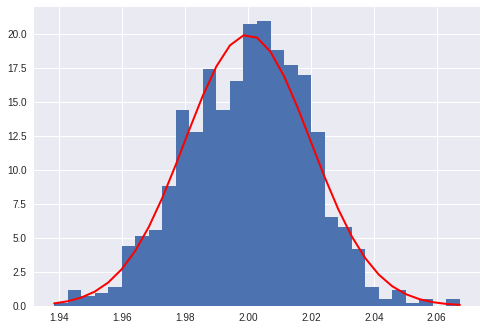

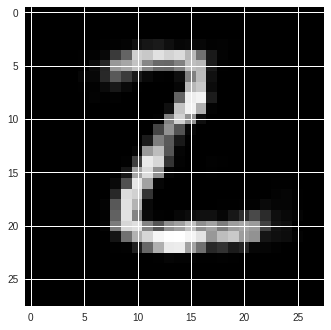

In [0]:
#Perturb the encoded string a little bit by adding Gaussian noise to it
mu, sigma = 2, 0.02

noise = np.random.normal(mu,sigma,1000)

count, bins, ignored = plt.hist(noise, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()
p = noise[0:encoding_size]

perturbed = encoded[1]+p
perturbed = perturbed.reshape(1,encoding_size)

decoded_perturbed = decoder.predict(perturbed)
plt.imshow(decoded_perturbed.reshape(28,28))
plt.show()

# Denoising autoencoder (DAE)
The only difference is that we induce masking noise in the form of dropout at the input layer. This will allow us to extract useful representations.

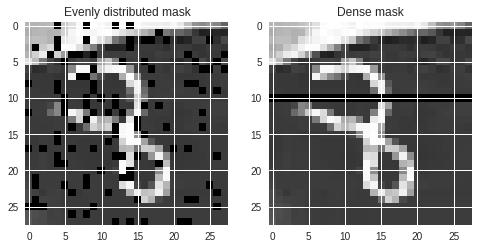

In [0]:
#Create a random mask consisting of 1s and 0s
rate = 0.15
my_mask = (np.random.rand(x_train.shape[0],x_train.shape[1]) > rate).astype(int)

#Mask the training data
x_masked = np.multiply(x_train,my_mask)

tmp = x_masked[1,:]
im = np.reshape(tmp,[28,28])
img = np.reshape(x_train[1,:],[28,28])
plt.subplot(1,2,1)
plt.title('Evenly distributed mask')
plt.imshow(im)

#We can also apply regional masking. For example: [0000
#                                                  0000
#                                                  1111
#                                                  1111]
mask2 = np.ones((28,28,x_train.shape[0]))

for i in range(x_train.shape[0]):
  lower = np.random.randint(low=0,high=18)
  margin = np.random.randint(low=0,high=12)
  mask2[lower:lower+margin,:,i] = 0

#Allow the data to be not corrupted (margin 0) or margin 18
  
mask2 = np.transpose(np.reshape(mask2,[784,x_train.shape[0]]))
tmp_mask = np.reshape(mask2[1,:],[28,28])
#plt.gray()
plt.subplot(1,2,2)
plt.imshow(np.multiply(img,tmp_mask))
plt.title('Dense mask')
plt.show()

x_masked2 = np.multiply(x_train,mask2)

def mask(rate,x_train):
  mask = (np.random.rand(x_train.shape[0],x_train.shape[1]) > rate).astype(int)
  x_masked = np.multiply(x_train,mask)
  return x_masked


In [0]:
encoding_size = 64 #Size of encoded layer

#Apply random masking to the input images

input = Input(shape=(784,))

y = Dense(encoding_size, activation='relu')(input)

z = Dense(784, activation='sigmoid')(y)
#Create the complete Autoencoder model
dae = Model(input,z)

#Take the first layer (y) of the AE and make it output of encoder model
dae_encoder = Model(input,y)

#Create a decoder model that uses the trained layer of the AE. This layer is the last one of the model.
input_decoder = Input(shape=(encoding_size,))

decoded_layer = dae.layers[-1]

dae_decoder = Model(input_decoder, decoded_layer(input_decoder))

#Compile the model
dae.compile(optimizer='adadelta',loss='binary_crossentropy')


In [0]:
dae.fit(x_masked,x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test,x_test),
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')])

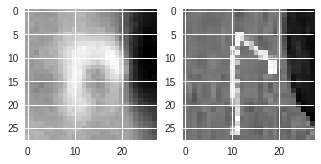

In [0]:
encoded = dae_encoder.predict(x_test)

#tmp = encoded[1].reshape(8,8)

#plt.gray()
#plt.subplot(1,3,1)
#plt.imshow(tmp)

decoded = dae_decoder.predict(encoded)

plt.subplot(1,3,2)
plt.imshow(decoded[1].reshape(28,28))

plt.subplot(1,3,3)
plt.imshow(x_test[1].reshape(28,28))
plt.show()


In [0]:
#Add some masking noise to the input and see what the decoder does with it
rate = 0.5
mask = (np.random.rand(x_train.shape[0],x_train.shape[1]) > rate).astype(int)

noisy_input = np.multiply(x_test,mask[0:x_test.shape[0],:])
plt.subplot(1,3,1)
plt.imshow(np.reshape(noisy_input[1,:],[28,28]))

noisy_encoded = dae_encoder.predict(noisy_input)
decoded_noisy = dae_decoder.predict(dae_encoder.predict(noisy_input))

plt.subplot(1,3,2)
plt.imshow(np.reshape(decoded_noisy[1,:],[28,28]))
plt.title('Reconstructed')

plt.subplot(1,3,3)
plt.imshow(np.reshape(x_test[1,:],[28,28]))
plt.show()

In [0]:
#Create another DAE, but train it with the dataset that is masked coarser

input = Input(shape=(784,))

y = Dense(encoding_size, activation='relu')(input)

z = Dense(784, activation='sigmoid')(y)
#Create the complete Autoencoder model
dae_masked = Model(input,z)

#Take the first layer (y) of the AE and make it output of encoder model
dae_masked_encoder = Model(input,y)

#Create a decoder model that uses the trained layer of the AE. This layer is the last one of the model.
input_decoder = Input(shape=(encoding_size,))

decoded_layer = dae.layers[-1]

dae_masked_decoder = Model(input_decoder, decoded_layer(input_decoder))


dae_masked.compile(optimizer='adadelta',loss='binary_crossentropy')
dae_masked.fit(x_masked2,x_train,epochs=70,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

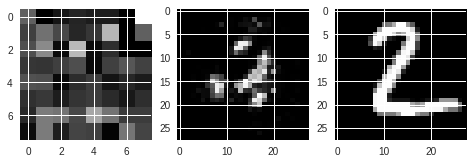

In [0]:

#Show the results on clean input
encoded = dae_masked_encoder.predict(x_test)

tmp = encoded[1].reshape(8,8)

plt.gray()
plt.subplot(1,3,1)
plt.imshow(tmp)

decoded = dae_masked_decoder.predict(encoded)

plt.subplot(1,3,2)
plt.imshow(decoded[1].reshape(28,28))

plt.subplot(1,3,3)
plt.imshow(x_test[1].reshape(28,28))
plt.show()


# Results
The following shows that for noisy input, the denoising auto encoder performs the best. In this case, the noise is of the same type the DAE was trained on. Therefore it is not a surprise that the DAE trained on that noisy data performs the best. However, given that the performance on clean input is better than the one of the AE suggests that the DAE has learned more valuable features.

In [0]:
#Add some masking noise to the input and see what the decoder does with it
#rate = 0.5
#mask = (np.random.rand(x_train.shape[0],x_train.shape[1]) > rate).astype(int)

noisy_input_dae2 = np.multiply(x_test,mask[0:x_test.shape[0],:])
plt.subplot(3,3,1)
plt.imshow(np.reshape(noisy_input_dae2[1,:],[28,28]))

decoded_noisy_dae2 = dae_masked_decoder.predict(dae_masked_encoder.predict(noisy_input))

plt.subplot(3,3,2)
plt.imshow(np.reshape(decoded_noisy_dae2[1,:],[28,28]))
plt.title('Reconstructed Mask 2 (DAE)')

plt.subplot(3,3,3)
plt.imshow(np.reshape(x_test[1,:],[28,28]))

#Show the results of random mask DAE
plt.subplot(3,3,4)
plt.imshow(np.reshape(noisy_input[1,:],[28,28]))


plt.subplot(3,3,5)
decoded_noisy = dae_decoder.predict(dae_encoder.predict(noisy_input))
plt.imshow(np.reshape(decoded_noisy[1,:],[28,28]))
plt.title('Reconstructed Mask 1 (DAE)')

plt.subplot(3,3,6)
plt.imshow(np.reshape(x_test[1,:],[28,28]))


#AE
plt.subplot(3,3,7)
plt.imshow(np.reshape(noisy_input[1,:],[28,28]))

decoded_noisy = decoder.predict(encoder.predict(noisy_input))
plt.subplot(3,3,8)
plt.imshow(np.reshape(decoded_noisy[1,:],[28,28]))
plt.title('Reconstructed (AE)')


plt.subplot(3,3,9)
plt.imshow(np.reshape(x_test[1,:],[28,28]))

plt.show()

# Stacked DAEs
Overall goal: Find a representation of the data that keeps as much information as possible (feature extraction).

What we are going to do:


1.   Train DAE on (x_train + noise)
2.   Feed clean inputs (x_train) and get output
3.   Use this output as "x_compr." and go to 1) with  "x_compr. + noise"




In [0]:
#Define input layer for first dae
#x_masked is noisy data to be trained on
first_encoding_size = 512
E0 = x_train
E0_masked = mask(0.15,x_train)
E0_test = x_test

input1 = Input(shape=(784,))
y1 = Dense(first_encoding_size, activation='relu')(input1)
z1 = Dense(784, activation='sigmoid')(y1)

#Create encoder
first_encoder = Model(input1,y1)

#Create first DAE of stack
first_dae = Model(input1,z1) #Layer z is output

#Create decoder
#Get last layer
input_first_decoder = Input(shape=(first_encoding_size,))
decoder_layer = first_dae.layers[-1]
first_decoder = Model(input_first_decoder,decoder_layer(input_first_decoder)) #Use the same layer. first_dae.layers[-1] returns callable layers

first_dae.compile(optimizer='adadelta',loss='binary_crossentropy')
first_dae.fit(E0_masked,E0,epochs=50,batch_size=256,shuffle=True,validation_data=(E0_test,E0_test),
             callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])




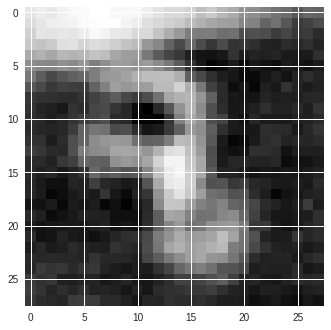

In [0]:
images = first_decoder.predict(first_encoder.predict(x_train))
plt.gray()
plt.imshow(np.reshape(images[1,:],[28,28]))
plt.show()

In [0]:
#Create second layer of stacked DAE
#First, get the data
second_encoding_size = 256
E1 = first_encoder.predict(x_train) #Encode clean data to a size of 64
E1_test = first_encoder.predict(x_test)
input2 = Input(shape=(E1.shape[1],))
E1_masked = mask(0.05,E1)
y2 = Dense(second_encoding_size, activation='relu')(input2)
z2 = Dense(E1.shape[1], activation='sigmoid')(y2)

#Create encoder
second_encoder = Model(input2,y2)

#Create second DAE of stack
second_dae = Model(input2,z2) #Layer z is output

#Create decoder
#Get last layer
input_second_decoder = Input(shape=(second_encoding_size,))
decoder_layer = second_dae.layers[-1]
second_decoder = Model(input_second_decoder,decoder_layer(input_second_decoder)) #Use the same layer. second_dae.layers[-1] returns callable layers

#Define a custom loss function, which transforms y_target and y_out to the images and does bin. crossentropy then

def _decoder_loss_first(y_true, y_pred):
    num_ex = K.shape(y_true)[0]
    y_t = first_decoder(K.reshape(y_true, (num_ex,512)))
    y_p = first_decoder(K.reshape(y_pred, (num_ex,512)))
    
    return keras.losses.binary_crossentropy(y_t,y_p)

second_dae.compile(optimizer='adadelta',loss=_decoder_loss_first)
second_dae.fit(E1_masked,E1,epochs=100,batch_size=256,shuffle=True,validation_data=(E1_test,E1_test),
               callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

In [0]:
#Quick sanity check:
E2 = second_decoder.predict(second_encoder.predict(E1)) #Predict on clean encoded signal
images = first_decoder.predict(E2)
img = images[1,:]
plt.gray()
plt.imshow(np.reshape(img,[28,28]))
plt.show()

In [0]:
#Create third layer of stacked DAE
#First, get the data
third_encoding_size = 64
E2 = second_encoder.predict(E1) #Predict clean input
E2_test = second_encoder.predict(E1_test)
input3 = Input(shape=(E2.shape[1],))
E2_masked = mask(0.0,E2)
y3 = Dense(third_encoding_size, activation='relu')(input3)
z3 = Dense(E2.shape[1], activation='sigmoid')(y3)

#Create encoder
third_encoder = Model(input3,y3)

#Create third DAE of stack
third_dae = Model(input3,z3) #Layer z is output

#Create custom loss
def _decoder_loss_second(y_true, y_pred):
    num_ex = K.shape(y_true)[0]
    y_t = first_decoder(second_decoder(K.reshape(y_true, (num_ex,256))))
    y_p = first_decoder(second_decoder(K.reshape(y_pred, (num_ex,256))))
    
    return keras.losses.binary_crossentropy(y_t,y_p)

#Create decoder
#Get last layer
input_third_decoder = Input(shape=(third_encoding_size,))
decoder_layer = third_dae.layers[-1]
third_decoder = Model(input_third_decoder,decoder_layer(input_third_decoder)) #Use the same layer. second_dae.layers[-1] returns callable layers

third_dae.compile(optimizer='adadelta',loss=_decoder_loss_second)
third_dae.fit(E2_masked,E2,epochs=200,batch_size=256,shuffle=True,validation_data=(E2_test,E2_test))

In [0]:
#Quick sanity check:
E3 = third_decoder.predict(third_encoder.predict(E2))
images = first_decoder.predict(second_decoder.predict(E3))
img = images[1,:]
plt.imshow(np.reshape(img,[28,28]))
plt.show()

In [0]:
#Create one big model that combines the three DAEs with one additional layer to a supervised setting
#Use SGD to fine-tune the parameters of the whole model
sdae_whole = Sequential()
sdae_whole.add(first_encoder.layers[0])
sdae_whole.add(first_encoder.layers[1])
sdae_whole.add(second_encoder.layers[0])
sdae_whole.add(second_encoder.layers[1])
sdae_whole.add(third_encoder.layers[0])
sdae_whole.add(third_encoder.layers[1])

sdae_whole.add(Dense(64, activation='relu')) #Add a small NN to classify
sdae_whole.add(Dense(10, activation='sigmoid')) #Output

sdae_whole.compile(optimizer='adadelta',loss='binary_crossentropy') #Fine tune the network for supervised task
sdae_whole.summary()
sdae_whole.fit(x_train,to_categorical(y_train),
                         epochs=40,batch_size=256,shuffle=False,
                         validation_data=(x_test,to_categorical(y_test)))


In [0]:
#Create a model using only the DAE (not the stacked version)
dae_whole = Sequential()
dae_whole.add(dae_encoder.layers[0])
dae_whole.add(dae_encoder.layers[1])
dae_whole.add(Dense(64, activation = 'relu'))
dae_whole.add(Dense(10, activation = 'sigmoid'))

dae_whole.compile(optimizer='adadelta',loss='binary_crossentropy') #adadelta produces better results, but for comparison
                                                              #this should be good enough
dae_whole.summary()
dae_whole.fit(x_train,to_categorical(y_train),
                         epochs=40,batch_size=256,shuffle=False,
                         validation_data=(x_test,to_categorical(y_test)))

# Results of SDAE and DAE pre trained NN classifier
**MNIST**

*   92.7% vs. 89.6%, sgd
*   98.0% vs. 97.3%, adadelta

**MNIST rot+background image


*   56% vs. 43%, adadelta, noise: [0.4,0.1,0]




In [0]:
#Predict and get accuracy of the model
y_hat = sdae_whole.predict(x_test)

y_pred = np.zeros(y_hat.shape[0])
for i in range(y_hat.shape[0]):
    y_pred[i] = np.argmax(y_hat[i,:])

acc = np.sum(y_pred == y_test)/len(y_pred)
print("SDAE accuracy: %s" % acc)

#Predict and get accuracy of the model
y_hat = dae_whole.predict(x_test)

y_pred = np.zeros(y_hat.shape[0])
for i in range(y_hat.shape[0]):
    y_pred[i] = np.argmax(y_hat[i,:])

acc = np.sum(y_pred == y_test)/len(y_pred)
print("DAE accuracy: %s" % acc)

NameError: ignored

**Comment on performance for mnist-rot-back**

We see that the **SDAE** performs way better than the single **DAE**, although they have the same representation size. However, both perform poorly. The main reason for this is the rotation. When humans try to do this task, they rotate the images in their head or even turn their head around. This would inspire a solution of learning a network that rotates the image to the most likely correct angle.
However, the point of this was to show the effect of stacked denoising autoencoders.